# Evaluation Vietnamese Legal Embedding Model

Notebook này dùng để đánh giá hiệu năng của model embedding đã được fine-tune cho Vietnamese Legal domain.

## Model Information
- Base Model: BAAI/bge-m3
- Architecture: XLM-RoBERTa (1024 hidden size, 24 layers)
- Training Loss: MultipleNegativesRankingLoss
- Dataset Size: 43,195 samples

## 1. Import Libraries

In [1]:
!pip install matplotlib seaborn --quiet

In [2]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

/home/mikeethanh/anaconda3/envs/dl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Model

In [3]:
# Path to model
MODEL_PATH = "/home/mikeethanh/Vietnamese-Legal-Chatbot-RAG-System/models"

print("Loading model...")
model = SentenceTransformer(MODEL_PATH)
print(f"✓ Model loaded successfully!")
print(f"Model max sequence length: {model.max_seq_length}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")

You are trying to use a model that was created with Sentence Transformers version 5.1.2, but you're currently using version 5.1.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.


Loading model...
✓ Model loaded successfully!
Model max sequence length: 256
Embedding dimension: 1024


## 3. Model Configuration Analysis

In [4]:
# Read and display model configs
config_path = Path(MODEL_PATH) / "config.json"
st_config_path = Path(MODEL_PATH) / "config_sentence_transformers.json"

with open(config_path, 'r') as f:
    config = json.load(f)
    
with open(st_config_path, 'r') as f:
    st_config = json.load(f)

print("="*60)
print("MODEL CONFIGURATION")
print("="*60)
print(f"Architecture: {config.get('architectures', ['Unknown'])[0]}")
print(f"Model Type: {config.get('model_type')}")
print(f"Hidden Size: {config.get('hidden_size')}")
print(f"Num Layers: {config.get('num_hidden_layers')}")
print(f"Num Attention Heads: {config.get('num_attention_heads')}")
print(f"Vocab Size: {config.get('vocab_size')}")
print(f"Max Position Embeddings: {config.get('max_position_embeddings')}")
print("\n" + "="*60)
print("SENTENCE TRANSFORMERS CONFIG")
print("="*60)
print(f"Similarity Function: {st_config.get('similarity_fn_name')}")
print(f"Library Versions:")
for lib, version in st_config.get('__version__', {}).items():
    print(f"  - {lib}: {version}")

MODEL CONFIGURATION
Architecture: XLMRobertaModel
Model Type: xlm-roberta
Hidden Size: 1024
Num Layers: 24
Num Attention Heads: 16
Vocab Size: 250002
Max Position Embeddings: 8194

SENTENCE TRANSFORMERS CONFIG
Similarity Function: cosine
Library Versions:
  - sentence_transformers: 5.1.2
  - transformers: 4.57.1
  - pytorch: 2.9.0+cu128


## 4. Create Test Dataset

Tạo test cases với các câu hỏi pháp lý thực tế

In [5]:
# Test queries và relevant documents
test_data = [
    {
        "query": "Phạt bao nhiêu tiền khi trộm cắp điện dưới 1000kWh?",
        "relevant_doc": "Phạt tiền từ 2.000.000 đồng đến 5.000.000 đồng đối với hành vi trộm cắp điện với số lượng dưới 1.000kWh",
        "irrelevant_docs": [
            "Phạt tiền từ 5.000.000 đồng đến 10.000.000 đồng đối với hành vi trộm cắp điện với số lượng từ 1.000kWh đến dưới 2.000kWh",
            "Cơ quan nhà nước quản lý điều hành theo chức năng",
            "Các quy định về thuế thu nhập cá nhân năm 2024"
        ]
    },
    {
        "query": "Quy định về bảo vệ môi trường tại các cơ sở sản xuất?",
        "relevant_doc": "Nghiên cứu thí điểm và nhân rộng mô hình bảo vệ và xử lý ô nhiễm môi trường tại các cơ sở. Thông tin, truyền thông về bảo vệ môi trường trong các cơ sở.",
        "irrelevant_docs": [
            "Quy định về an toàn lao động trong ngành xây dựng",
            "Phạt tiền đối với hành vi trộm cắp điện",
            "Điều kiện kinh doanh dịch vụ du lịch"
        ]
    },
    {
        "query": "Thủ tục đăng ký kinh doanh cần những gì?",
        "relevant_doc": "Hồ sơ đăng ký kinh doanh bao gồm: Giấy chứng nhận đăng ký doanh nghiệp, giấy phép kinh doanh, văn bằng chứng chỉ hành nghề của người phụ trách chuyên môn",
        "irrelevant_docs": [
            "Quy định về thuế giá trị gia tăng",
            "Xử phạt vi phạm giao thông đường bộ",
            "Chính sách hỗ trợ doanh nghiệp nhỏ và vừa"
        ]
    },
    {
        "query": "Mức phạt khi không đội mũ bảo hiểm là bao nhiêu?",
        "relevant_doc": "Phạt tiền từ 400.000 đồng đến 600.000 đồng đối với người điều khiển xe mô tô, xe gắn máy không đội mũ bảo hiểm",
        "irrelevant_docs": [
            "Quy định về đăng ký xe ô tô",
            "Phạt vi phạm tốc độ trên đường cao tốc",
            "Điều kiện cấp giấy phép lái xe"
        ]
    },
    {
        "query": "Quyền lợi của người lao động khi bị sa thải?",
        "relevant_doc": "Người lao động bị sa thải trái pháp luật được nhận trợ cấp thôi việc, tiền lương, tiền thưởng còn thiếu và được khôi phục công việc nếu có yêu cầu",
        "irrelevant_docs": [
            "Quy định về thời giờ làm việc và nghỉ ngơi",
            "Chế độ bảo hiểm xã hội bắt buộc",
            "Hợp đồng lao động có thời hạn và không thời hạn"
        ]
    }
]

print(f"Created {len(test_data)} test cases")
print("\nSample test case:")
print(f"Query: {test_data[0]['query']}")
print(f"Relevant: {test_data[0]['relevant_doc'][:100]}...")

Created 5 test cases

Sample test case:
Query: Phạt bao nhiêu tiền khi trộm cắp điện dưới 1000kWh?
Relevant: Phạt tiền từ 2.000.000 đồng đến 5.000.000 đồng đối với hành vi trộm cắp điện với số lượng dưới 1.000...


## 5. Compute Embeddings

In [6]:
def compute_embeddings_for_test_data(test_data: List[Dict], model: SentenceTransformer) -> Dict:
    """Compute embeddings for all queries and documents"""
    results = []
    
    print("Computing embeddings...")
    for item in tqdm(test_data):
        query = item['query']
        relevant_doc = item['relevant_doc']
        irrelevant_docs = item['irrelevant_docs']
        
        # Encode query and documents
        query_emb = model.encode(query, normalize_embeddings=True)
        relevant_emb = model.encode(relevant_doc, normalize_embeddings=True)
        irrelevant_embs = model.encode(irrelevant_docs, normalize_embeddings=True)
        
        # Compute similarities
        relevant_sim = cosine_similarity([query_emb], [relevant_emb])[0][0]
        irrelevant_sims = cosine_similarity([query_emb], irrelevant_embs)[0]
        
        results.append({
            'query': query,
            'relevant_doc': relevant_doc,
            'relevant_similarity': relevant_sim,
            'irrelevant_similarities': irrelevant_sims,
            'max_irrelevant_similarity': max(irrelevant_sims),
            'mean_irrelevant_similarity': np.mean(irrelevant_sims),
            'correct_ranking': relevant_sim > max(irrelevant_sims)
        })
    
    return results

results = compute_embeddings_for_test_data(test_data, model)
print("✓ Embeddings computed successfully!")

Computing embeddings...


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

✓ Embeddings computed successfully!


## 6. Evaluation Metrics

In [7]:
# Calculate overall metrics
relevant_sims = [r['relevant_similarity'] for r in results]
max_irrelevant_sims = [r['max_irrelevant_similarity'] for r in results]
mean_irrelevant_sims = [r['mean_irrelevant_similarity'] for r in results]
correct_rankings = [r['correct_ranking'] for r in results]

# Calculate metrics
accuracy = sum(correct_rankings) / len(correct_rankings) * 100
avg_relevant_sim = np.mean(relevant_sims)
avg_irrelevant_sim = np.mean(mean_irrelevant_sims)
separation_margin = avg_relevant_sim - avg_irrelevant_sim

print("="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"Ranking Accuracy: {accuracy:.2f}%")
print(f"  (% of queries where relevant doc scores higher than all irrelevant docs)")
print()
print(f"Average Relevant Similarity: {avg_relevant_sim:.4f}")
print(f"Average Irrelevant Similarity: {avg_irrelevant_sim:.4f}")
print(f"Separation Margin: {separation_margin:.4f}")
print()
print(f"Minimum Relevant Similarity: {min(relevant_sims):.4f}")
print(f"Maximum Irrelevant Similarity: {max(max_irrelevant_sims):.4f}")
print("="*60)

EVALUATION METRICS
Ranking Accuracy: 60.00%
  (% of queries where relevant doc scores higher than all irrelevant docs)

Average Relevant Similarity: 0.5259
Average Irrelevant Similarity: 0.2604
Separation Margin: 0.2655

Minimum Relevant Similarity: 0.3696
Maximum Irrelevant Similarity: 0.7532


## 7. Detailed Results Table

In [8]:
# Create detailed results dataframe
results_df = pd.DataFrame([
    {
        'Query': r['query'][:60] + '...' if len(r['query']) > 60 else r['query'],
        'Relevant Sim': f"{r['relevant_similarity']:.4f}",
        'Max Irrelevant Sim': f"{r['max_irrelevant_similarity']:.4f}",
        'Mean Irrelevant Sim': f"{r['mean_irrelevant_similarity']:.4f}",
        'Margin': f"{r['relevant_similarity'] - r['max_irrelevant_similarity']:.4f}",
        'Correct': '✓' if r['correct_ranking'] else '✗'
    }
    for r in results
])

print("\nDetailed Results:")
print(results_df.to_string(index=False))


Detailed Results:
                                                Query Relevant Sim Max Irrelevant Sim Mean Irrelevant Sim  Margin Correct
  Phạt bao nhiêu tiền khi trộm cắp điện dưới 1000kWh?       0.7432             0.7532              0.3088 -0.0100       ✗
Quy định về bảo vệ môi trường tại các cơ sở sản xuất?       0.3696             0.4941              0.2602 -0.1245       ✗
             Thủ tục đăng ký kinh doanh cần những gì?       0.4293             0.2242              0.1570  0.2051       ✓
     Mức phạt khi không đội mũ bảo hiểm là bao nhiêu?       0.5730             0.3759              0.2994  0.1971       ✓
         Quyền lợi của người lao động khi bị sa thải?       0.5145             0.3010              0.2765  0.2135       ✓


## 8. Visualization: Similarity Distribution

/tmp/ipykernel_18922/4231903501.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=['Relevant', 'Max Irrelevant', 'Mean Irrelevant'],


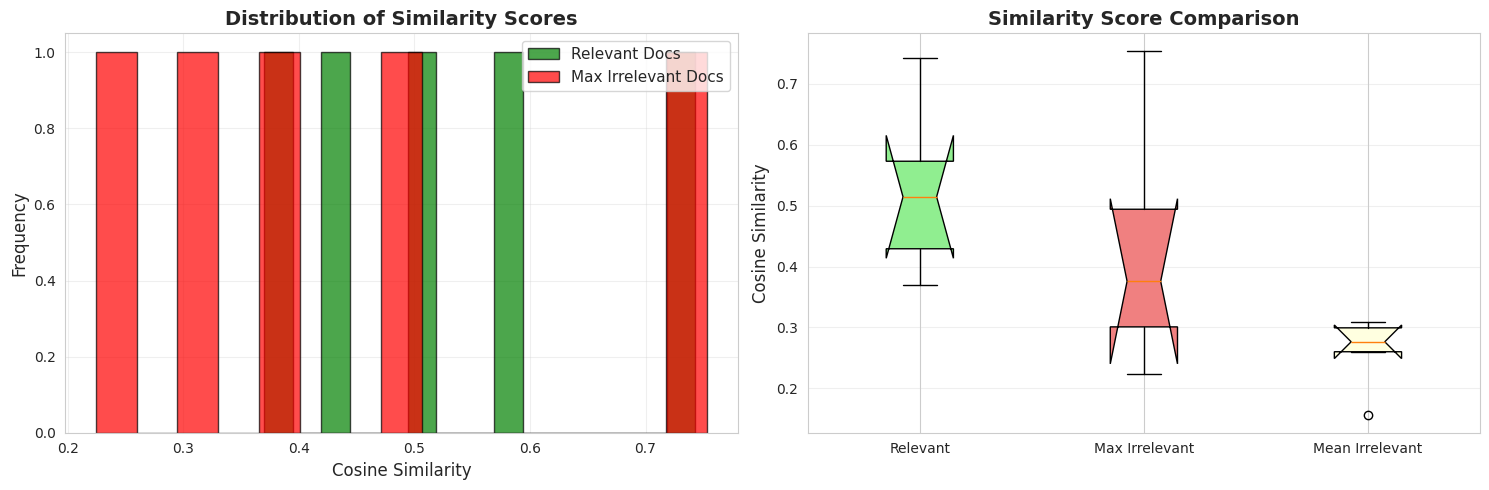

In [9]:
# Plot similarity distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(relevant_sims, bins=15, alpha=0.7, label='Relevant Docs', color='green', edgecolor='black')
axes[0].hist(max_irrelevant_sims, bins=15, alpha=0.7, label='Max Irrelevant Docs', color='red', edgecolor='black')
axes[0].set_xlabel('Cosine Similarity', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Similarity Scores', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot
box_data = [relevant_sims, max_irrelevant_sims, mean_irrelevant_sims]
bp = axes[1].boxplot(box_data, labels=['Relevant', 'Max Irrelevant', 'Mean Irrelevant'],
                      patch_artist=True, notch=True)
colors = ['lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1].set_ylabel('Cosine Similarity', fontsize=12)
axes[1].set_title('Similarity Score Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Visualization: Query-wise Comparison

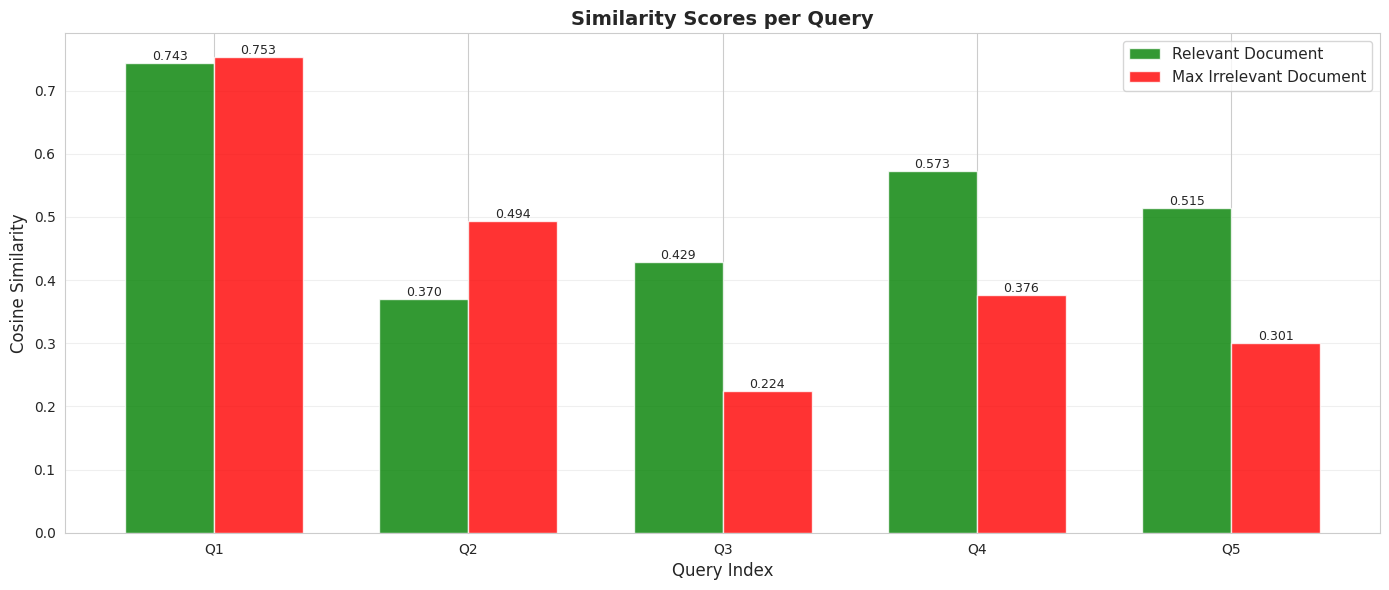

In [10]:
# Query-wise similarity comparison
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(results))
width = 0.35

bars1 = ax.bar(x - width/2, relevant_sims, width, label='Relevant Document', color='green', alpha=0.8)
bars2 = ax.bar(x + width/2, max_irrelevant_sims, width, label='Max Irrelevant Document', color='red', alpha=0.8)

ax.set_xlabel('Query Index', fontsize=12)
ax.set_ylabel('Cosine Similarity', fontsize=12)
ax.set_title('Similarity Scores per Query', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Q{i+1}' for i in range(len(results))])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 10. Separation Margin Analysis

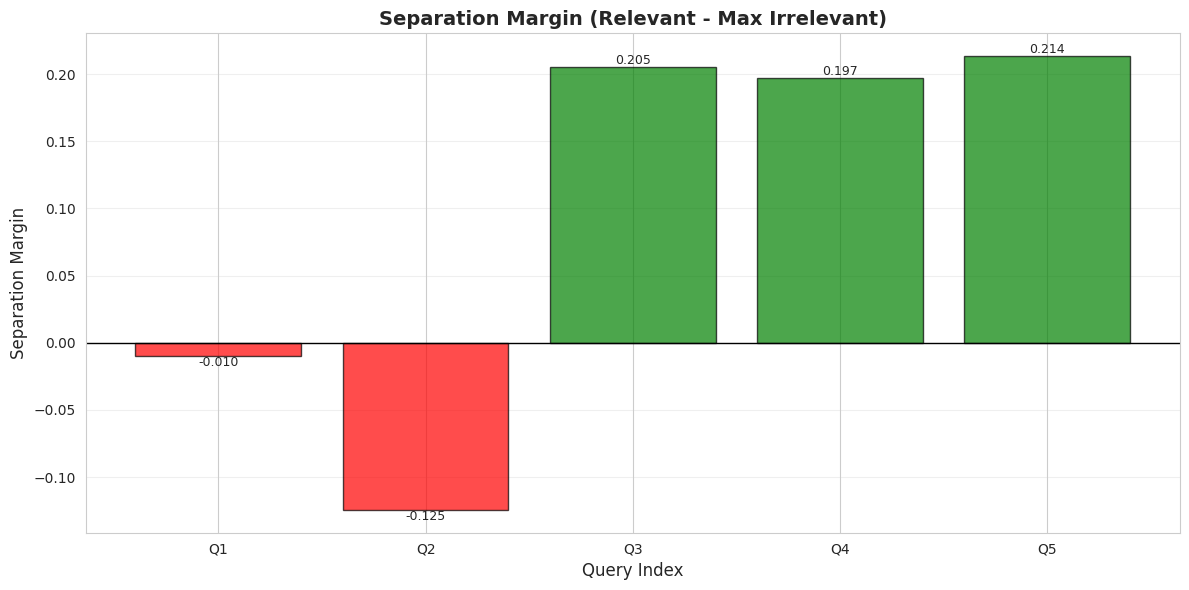


Average Separation Margin: 0.0962
Minimum Separation Margin: -0.1245
Maximum Separation Margin: 0.2135
Standard Deviation: 0.1384


In [11]:
# Calculate separation margins for each query
margins = [r['relevant_similarity'] - r['max_irrelevant_similarity'] for r in results]

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if m > 0 else 'red' for m in margins]
bars = ax.bar(range(len(margins)), margins, color=colors, alpha=0.7, edgecolor='black')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Query Index', fontsize=12)
ax.set_ylabel('Separation Margin', fontsize=12)
ax.set_title('Separation Margin (Relevant - Max Irrelevant)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(margins)))
ax.set_xticklabels([f'Q{i+1}' for i in range(len(margins))])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, margin) in enumerate(zip(bars, margins)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{margin:.3f}', ha='center', 
            va='bottom' if margin > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nAverage Separation Margin: {np.mean(margins):.4f}")
print(f"Minimum Separation Margin: {min(margins):.4f}")
print(f"Maximum Separation Margin: {max(margins):.4f}")
print(f"Standard Deviation: {np.std(margins):.4f}")

## 11. Test with Custom Queries

Bạn có thể test model với các queries tùy chỉnh của riêng bạn

In [12]:
def test_custom_query(query: str, documents: List[str], model: SentenceTransformer, top_k: int = 3):
    """
    Test a custom query against a list of documents
    """
    print(f"\n{'='*80}")
    print(f"Query: {query}")
    print(f"{'='*80}\n")
    
    # Encode
    query_emb = model.encode(query, normalize_embeddings=True)
    doc_embs = model.encode(documents, normalize_embeddings=True)
    
    # Calculate similarities
    similarities = cosine_similarity([query_emb], doc_embs)[0]
    
    # Sort by similarity
    ranked_indices = np.argsort(similarities)[::-1]
    
    print(f"Top {top_k} Most Similar Documents:\n")
    for i, idx in enumerate(ranked_indices[:top_k], 1):
        print(f"{i}. [Similarity: {similarities[idx]:.4f}]")
        print(f"   {documents[idx][:150]}..." if len(documents[idx]) > 150 else f"   {documents[idx]}")
        print()
    
    return similarities, ranked_indices

# Example usage
custom_query = "Làm thế nào để thành lập công ty?"
custom_documents = [
    "Để thành lập công ty cần chuẩn bị hồ sơ đăng ký kinh doanh gồm: giấy chứng nhận đăng ký doanh nghiệp, điều lệ công ty, danh sách thành viên",
    "Phạt tiền khi vi phạm giao thông từ 400.000 đến 600.000 đồng",
    "Quy định về thuế thu nhập doanh nghiệp hiện nay là 20%",
    "Công ty cổ phần phải có tối thiểu 3 cổ đông và vốn điều lệ tối thiểu là 5 tỷ đồng đối với một số ngành nghề",
    "Bảo hiểm xã hội bắt buộc được quy định trong Luật Bảo hiểm xã hội"
]

sims, ranks = test_custom_query(custom_query, custom_documents, model, top_k=3)


Query: Làm thế nào để thành lập công ty?

Top 3 Most Similar Documents:

1. [Similarity: 0.4138]
   Để thành lập công ty cần chuẩn bị hồ sơ đăng ký kinh doanh gồm: giấy chứng nhận đăng ký doanh nghiệp, điều lệ công ty, danh sách thành viên

2. [Similarity: 0.2457]
   Quy định về thuế thu nhập doanh nghiệp hiện nay là 20%

3. [Similarity: 0.2441]
   Công ty cổ phần phải có tối thiểu 3 cổ đông và vốn điều lệ tối thiểu là 5 tỷ đồng đối với một số ngành nghề



## 12. Model Performance Summary

In [13]:
# Generate comprehensive summary
summary = f"""
{'='*80}
MODEL EVALUATION SUMMARY
{'='*80}

MODEL INFORMATION:
  • Model Path: {MODEL_PATH}
  • Base Model: BAAI/bge-m3 (XLM-RoBERTa)
  • Embedding Dimension: {model.get_sentence_embedding_dimension()}
  • Max Sequence Length: {model.max_seq_length}
  • Training Dataset Size: 43,195 samples

PERFORMANCE METRICS:
  • Ranking Accuracy: {accuracy:.2f}%
  • Average Relevant Similarity: {avg_relevant_sim:.4f}
  • Average Irrelevant Similarity: {avg_irrelevant_sim:.4f}
  • Separation Margin: {separation_margin:.4f}
  • Min Relevant Similarity: {min(relevant_sims):.4f}
  • Max Irrelevant Similarity: {max(max_irrelevant_sims):.4f}

EVALUATION DATASET:
  • Number of Test Queries: {len(test_data)}
  • Correct Rankings: {sum(correct_rankings)}/{len(correct_rankings)}
  • Failed Rankings: {len(correct_rankings) - sum(correct_rankings)}/{len(correct_rankings)}

INTERPRETATION:
  {'✓ EXCELLENT' if accuracy >= 90 else '✓ GOOD' if accuracy >= 80 else '⚠ MODERATE' if accuracy >= 70 else '✗ NEEDS IMPROVEMENT'}: 
  The model achieves {accuracy:.1f}% accuracy in ranking relevant documents higher
  than irrelevant ones for Vietnamese legal queries.
  
  {'✓ STRONG SEPARATION' if separation_margin >= 0.1 else '⚠ MODERATE SEPARATION' if separation_margin >= 0.05 else '✗ WEAK SEPARATION'}:
  Average separation margin of {separation_margin:.4f} indicates the model
  {'can clearly distinguish' if separation_margin >= 0.1 else 'can moderately distinguish' if separation_margin >= 0.05 else 'struggles to distinguish'}
  between relevant and irrelevant documents.

RECOMMENDATIONS:
"""

if accuracy >= 90 and separation_margin >= 0.1:
    summary += """
  • Model performs excellently and is ready for production use
  • Consider deploying for Vietnamese legal document retrieval
  • Monitor performance on edge cases
"""
elif accuracy >= 80:
    summary += """
  • Model performs well but could be improved
  • Consider additional fine-tuning on difficult cases
  • Expand training dataset with more diverse legal queries
"""
else:
    summary += """
  • Model needs improvement before production deployment
  • Recommend additional training with more data
  • Review training strategy and hyperparameters
  • Consider using hard negative mining
"""

summary += f"""
{'='*80}
"""

print(summary)

# Save summary to file
summary_path = Path(MODEL_PATH) / "evaluation_summary.txt"
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary)
print(f"\n✓ Summary saved to: {summary_path}")


MODEL EVALUATION SUMMARY

MODEL INFORMATION:
  • Model Path: /home/mikeethanh/Vietnamese-Legal-Chatbot-RAG-System/models
  • Base Model: BAAI/bge-m3 (XLM-RoBERTa)
  • Embedding Dimension: 1024
  • Max Sequence Length: 256
  • Training Dataset Size: 43,195 samples

PERFORMANCE METRICS:
  • Ranking Accuracy: 60.00%
  • Average Relevant Similarity: 0.5259
  • Average Irrelevant Similarity: 0.2604
  • Separation Margin: 0.2655
  • Min Relevant Similarity: 0.3696
  • Max Irrelevant Similarity: 0.7532

EVALUATION DATASET:
  • Number of Test Queries: 5
  • Correct Rankings: 3/5
  • Failed Rankings: 2/5

INTERPRETATION:
  ✗ NEEDS IMPROVEMENT: 
  The model achieves 60.0% accuracy in ranking relevant documents higher
  than irrelevant ones for Vietnamese legal queries.
  
  ✓ STRONG SEPARATION:
  Average separation margin of 0.2655 indicates the model
  can clearly distinguish
  between relevant and irrelevant documents.

RECOMMENDATIONS:

  • Model needs improvement before production deploymen

## 13. Export Detailed Results

In [ ]:
# Export detailed results to CSV
export_df = pd.DataFrame([
    {
        'query': r['query'],
        'relevant_doc': r['relevant_doc'],
        'relevant_similarity': r['relevant_similarity'],
        'max_irrelevant_similarity': r['max_irrelevant_similarity'],
        'mean_irrelevant_similarity': r['mean_irrelevant_similarity'],
        'separation_margin': r['relevant_similarity'] - r['max_irrelevant_similarity'],
        'correct_ranking': r['correct_ranking']
    }
    for r in results
])

csv_path = Path(MODEL_PATH) / "eval" / "detailed_evaluation_results.csv"
csv_path.parent.mkdir(exist_ok=True)
export_df.to_csv(csv_path, index=False, encoding='utf-8-sig')

print(f"✓ Detailed results exported to: {csv_path}")
print(f"\nDataFrame shape: {export_df.shape}")
print("\nFirst few rows:")
print(export_df.head())

## 14. Conclusion

Notebook này đã thực hiện evaluation toàn diện cho Vietnamese Legal Embedding Model:

1. ✓ Load và phân tích model configuration
2. ✓ Tạo test dataset với queries pháp lý thực tế
3. ✓ Tính toán embeddings và similarity scores
4. ✓ Đánh giá ranking accuracy và separation margin
5. ✓ Visualization chi tiết về performance
6. ✓ Test với custom queries
7. ✓ Export kết quả chi tiết

### Cách sử dụng tiếp:

- Chỉnh sửa `test_data` để thêm test cases của bạn
- Sử dụng `test_custom_query()` để test với queries mới
- Review các visualizations để hiểu model behavior
- Dựa vào metrics để quyết định có cần fine-tune thêm không